# Задачи курса
1. Считать аудио файл (можно использовать библиотечные функции)
2. Научится добавлять писк (правильно подобранная синусойда) к аудио данным и записывать файл обратно.
3. Посчитать спектрограмму (нужно реализовать самостоятельно)
4. Показать влияние синусойды
5. Реализовать фильтр Чебышёва (во временной шкале) для того чтобы убрать писк
6. Показать какое влияние оказывает на спектрограмму.
7. Выделить гармоники, хотя бы главную.
8. Построить её график.
9. Реализовать корректное ускорение/замедление проигрывания не искажающее частоту.

Фактически все нужно реализовать вручную. Пункты можно объединять если это удобно в одну программу.
Язык любой. Файл лучше поищите сами. Формат наверное wav.
Ограничения. Время работы должно быть не больше десятка секунд на каждый из рассматриваемых пунктов при показе. т.е. эффективность с точки зрения теории алгоритмов не учитывается

### Источники информации
https://vk.com/doc-132177380_490658870?hash=32f012da237dd9993d&dl=2af63196e312a1dd15  
http://www.mai-trt.ru/docs/edu/lek_or_ruch_06.pdf  
http://www.mai-trt.ru/docs/edu/lek_or_ruch_07.pdf  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display as ipd  # для воспроизведения аудио-файла
from librosa import display         # для визуализации

import ReadWriteNoise  as RWN       # задачи 1-2
import Spectrogram     as Sp        # задача 3 (+ задачи 4,6)
import ChebyshevFilter as ChF       # задача 5
import Harmonics       as H         # задачи 7-8

Для иллюстрации полученных результатов будем использовать следующие функции.

In [9]:
# для визуализации в блокноте
def waveplot(x, sr):
    plt.style.use('ggplot')
    plt.figure(figsize=(14, 5))
    display.waveplot(x, sr=sr)

In [37]:
# для визуализации в блокноте
'''
Зависимость амплитуды от частоты для выбранного окна. Предлагается также изобразить
график, полученный после одного из приемов сглаживания  
'''
def plot_amplitude(spectrogram, window_number, sample_rate,\
                   simple = True, mean = False, mean_w = True, gauss = True,\
                   box_len = 9, sigma = 2):
    if simple or mean or mean_w or gauss:
        plt.figure (figsize = (20, 8))
        if simple:
            plt.plot(spectrogram[window_number], label = 'simple max')
        if mean:
            plt.plot(H.smoothing_mean(spectrogram[window_number], box_len), label = 'boxed mean')
        if mean_w:
            plt.plot(H.smoothing_mean_w(spectrogram[window_number], box_len), label = 'boxed weights mean')
        if gauss:
            plt.plot(H.gaussian_filter(spectrogram[window_number], sigma), label = 'gaussian filter')
        
        ## подписываем ось x
        x_dash_n = 15
        x_ticks  = np.linspace (0, spectrogram.shape[1], x_dash_n)                         # положение делений - номер
        x_labels = [int(sample_rate*pos/spectrogram.shape[1]) for pos in x_ticks]          # метки делений - частота
        plt.xticks (x_ticks, x_labels)
        plt.xlabel("Hz")
        plt.ylabel("Amplitude")
        plt.legend()

In [43]:
# для визуализации в блокноте
'''
Покажем, где выделяются максимальные амплитуды
'''
def show_3_max(spectrogram, window_number, sample_rate, smooth_function = H.gaussian_filter):
    wind = spectrogram[window_number]
    wind_sm = smooth_function (wind)
    lm,lmp = H.find_local_max(wind_sm, box_len = 3)
    number_of_harmonics = 3
    h = []
    lm_copy = lm 
    for hn in range(number_of_harmonics):
        pos = np.argmax(lm_copy)
        lm_copy[pos] = 0.0                 #занулим текущий максимум, чтобы найти следующий
        h.append(lmp[pos])
    
    colors = ['red', 'green', 'orange']
    labels = ['1', '2', '3']
    plt.figure(figsize=(20, 8))
    plt.plot(wind, color = 'gray')
    plt.plot(wind_sm)
    for i in range(number_of_harmonics):
        plt.axvline(x=h[i], ymin=0.005, ymax=20, color = colors[i], label = labels[i])
     
    ## подписываем ось x
    x_dash_n = 15
    x_ticks  = np.linspace (0, spectrogram.shape[1], x_dash_n)                         # положение делений - номер
    x_labels = [int(sample_rate*pos/spectrogram.shape[1]) for pos in x_ticks]          # метки делений - частота
    plt.xticks (x_ticks, x_labels)
    plt.xlabel("Hz")
    plt.ylabel("Amplitude")
    plt.legend()

Аудио-файлы:

In [7]:
wavName = 'AudioFiles/guitar.wav'
#wavName = 'AudioFiles/celtic.wav'
#wavName = 'AudioFiles/pianino.wav'
#wavName = 'AudioFiles/pchela.wav'
#wavName = 'AudioFiles/nizkochastotnyj_zvuk.wav'
#wavName = 'AudioFiles/wicked_game.wav'

# Задача 1. Считывание файла

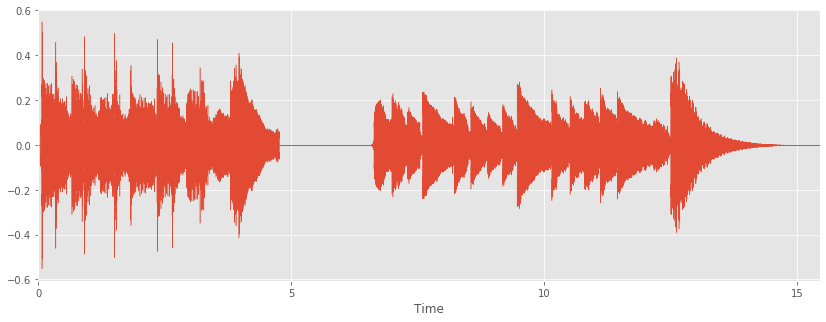

In [17]:
x, sr = RWN.read_audio(wavName)

waveplot(x, sr)
ipd.Audio(x, rate=sr)

# Задача 2. Добавление писка

В качестве писка выбран звук с частотой (по умолчанию) 15 кГц (примерный диапозон частот звука, слышимых человеком от 20 Гц до 20 кГц)

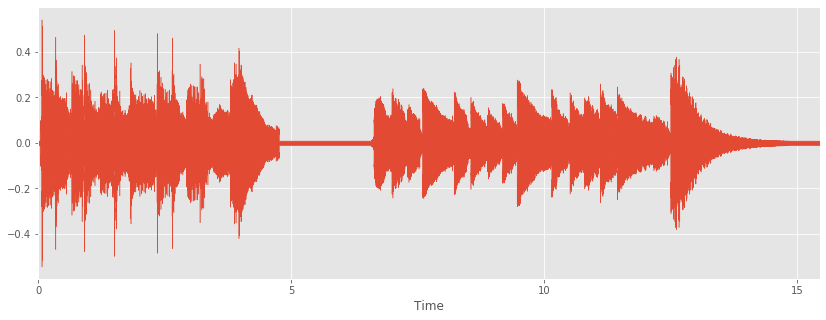

In [5]:
x_noise = RWN.add_noise(x, sr) #f_noise = 15000

waveplot(x_noise, sr)
ipd.Audio(x_noise, rate=sr)

In [6]:
RWN.write_audio(wavName[:-4] + "_noise.wav", x,sr)

written to 'AudioFiles/guitar_noise.wav'


# Задача 3. Спектрограмма

Построение **спектрограммы** является универсальным методом, позволяющем визуализировать эволюцию спектра сигнала во времени. В основе спектрограммы лежит оконное преобразовании Фурье, суть которого заключается в разбиение сигнала (во временном представление) на на равные небольшие промежутки, называемые окнами, и последующем Фурье преобразование для каждого окна. В результате получаем набор частот, со своими амплитудами, значение которых меняется от окна к окну.
При построении спектрограммы поступают следующим образом. По горизонтальной оси откладывают время (соответствует номеру окна), а по вертикальной оси частоту. Амплитуды, соответствующие конкретным частотам, откладывают в логарифмическом масштабе. На спектрограмме они задаются при помощи цвета.

In [6]:
wind_n = 1000
print("window -- time: {}".format(len(x) / (sr*wind_n)))

window -- time: 0.015451383219954649


sound time series length: 340703
spectrogram shape: (1000, 340)


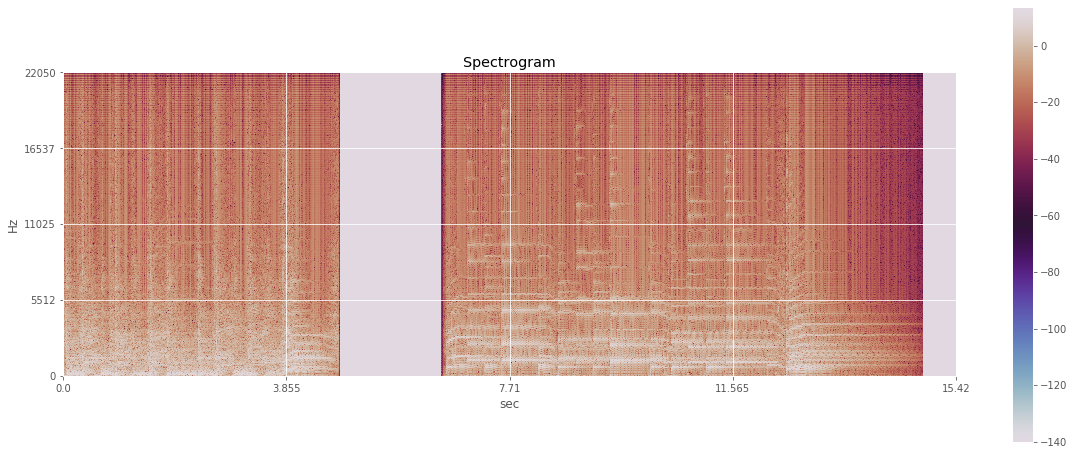

In [7]:
spect, wind_l = Sp.make_spectrogram(x,wind_n)
Sp.plot_spectrogramm (spect.T, sr, wind_l, len(x), wind_n)

Сравним с библиотечной функцией `librosa.display.specshow`

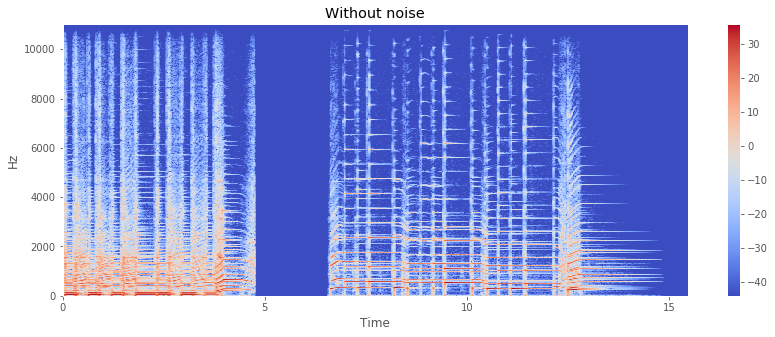

In [17]:
# библиотечная функция
from librosa import stft,  amplitude_to_db
from librosa.display import specshow

X = stft(x)
Xdb = amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title("Without noise")
specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Задача 4. Спектрограмма. Влияние писка.

sound time series length: 340703
spectrogram shape: (1000, 340)


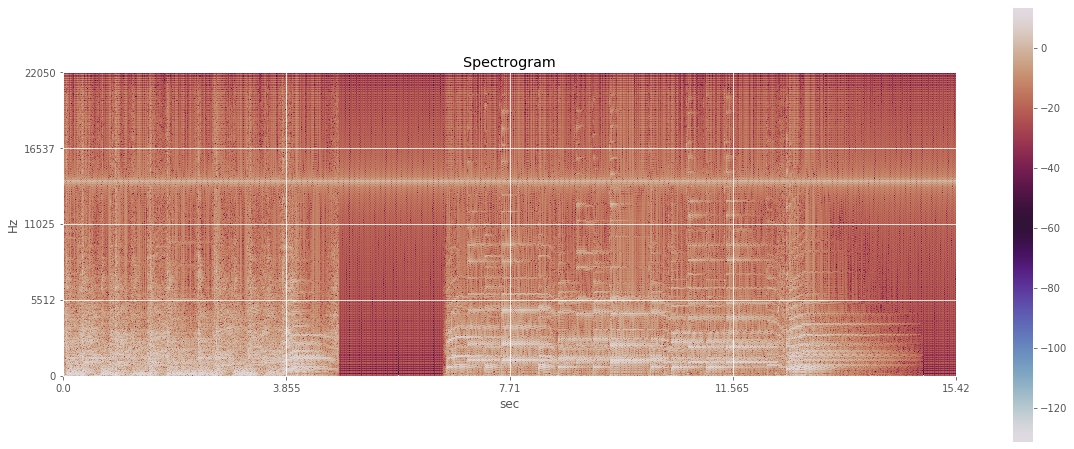

In [8]:
spect_noise, wind_l = Sp.make_spectrogram(x_noise,wind_n)
Sp.plot_spectrogramm (spect_noise.T, sr, wind_l, len(x), wind_n)

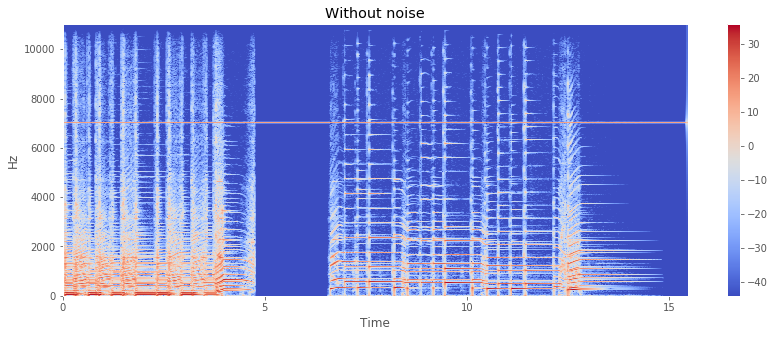

In [10]:
# библиотечная функция
from librosa import stft,  amplitude_to_db
from librosa.display import specshow

X = stft(x_noise)
Xdb = amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title("Without noise")
specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Задача 5. Фильтр Чебышева

Для начала рассмотрим понятие коэффициента передачи. Входной и выходной сигнал можно представить в виде интеграла Фурье и определить коэффициент передачи цепи $K(\omega)$ как

$$K(\omega) = \frac{U_{\text{вых}}(\omega) }{U_{\text{вх}}(\omega) } = |K(\omega)|e^{i arg(K(\omega))}$$

Введем нормированную частоту $\Omega = \frac{\omega}{\omega_0}$, где $\omega_0$ - граничная частота полосы пропускания (полосы, в которой выделяется сигнал).   
Обобщенная формула амплитудно-частотной характеристики для фильтра низких частот:

$$K(\Omega) = \frac{1}{\sqrt{1 + \varepsilon^2 F(\Omega)}}$$

Здесь $F(\Omega)$ - фунция фильтрации, она определяется типом фильтра. Для любой функции фильтрации стправедливо $F(1) = 1$

В **фильтрах Чебышева** в качестве функции фильтрации  используется квадрат полинома Чебышева 

$$F(\Omega) = T_n^2(\Omega)$$

Многочлены Чебышёва первого рода $T_n(x)$ могут быть определены с помощью рекуррентного соотношения:

$$T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x),\quad T_0(x) = 1\ ,\ T_1(x) = x $$
Примеры полиномов Чебышева:  
$\begin{array}
& T_0(x) = & 1\ ;               & T_1(x) = & x \\
  T_2(x) = & 2x^2 - 1\ ;        & T_3(x) = & 4x^3 - 3x\\
  T_4(x) = & 8x^4 - 8x^2 + 1\ ; & T_5(x) = & 16x^5 - 20x^3 + 5x
\end{array}$ 



В рамках данной задачи были выбраны следующие параметры, задающие фильтр Чебышева:
$$\omega_0 = 12000$$
$$\varepsilon = 0.07$$
$$F(\Omega) = T_{15}^2(\Omega)$$

In [4]:
# граничная частота
w0 = 12000
# параметр коэффициента передачи
eps = 0.07
# степень полинома Чебышева
deg = 15

  
Ниже представлен график $K(x)$ для выбранных параметров. Коротко и своими словаи его можно описать следующим образом. Поведение графика при $x < 1$ соответтвует деформации сигнала, который мы считаем "эталонным": чем больше отклонение графика от единицы - тем больше деформация. Поведение графика при $x > 1$ соответвует качеству фильтрации "плохого" сигала: чем ближе график к прямой $x = 1$, тем лучше фильтрация.  
Точка перечесечения графика $K(x)$ и прямой, соответвующей писку, показывает во сколько раз уменьшится его частота.  


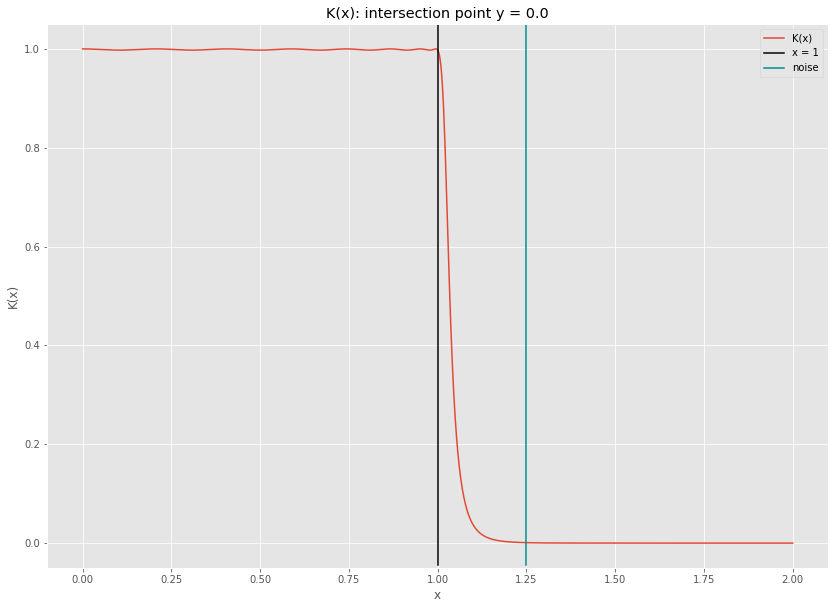

In [5]:
def K(x):
    return 1/np.sqrt(1 + eps**2 * ChF.cheb_function(deg, x)**2)

grid = np.linspace(0, 2, 1000)
plt.style.use('ggplot')
plt.figure(figsize=(14, 10))
plt.title("K(x): intersection point y = {}".format(round( K(1.5), 4 )))
plt.plot(grid, [K(x) for x in grid], label = "K(x)" )                                 # K(x)
plt.axvline(x=1,   ymin=0.005, ymax=1.0, color = 'black',    label = "x = 1")         # x = 1
plt.axvline(x=15000/w0, ymin=0.005, ymax=1.0, color = 'darkcyan', label = "noise")    # x = c (частота писка)
plt.xlabel("x")
plt.ylabel("K(x)")
plt.legend()

А вот и сам фильтр Чебышева

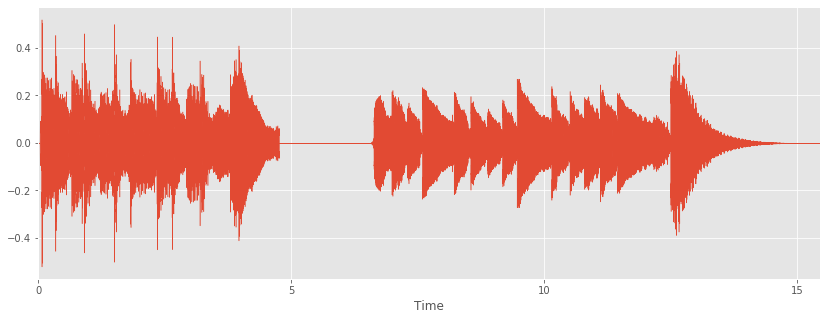

In [14]:
x_noise_filter = ChF.chebyshev_noise_filter(x_noise, w0, sr, deg, eps)

waveplot(x_noise_filter, sr)
ipd.Audio(x_noise_filter, rate=sr)

# Задача 6. Фильтр Чебышева. Спектрограмма

sound time series length: 340703
spectrogram shape: (1000, 340)


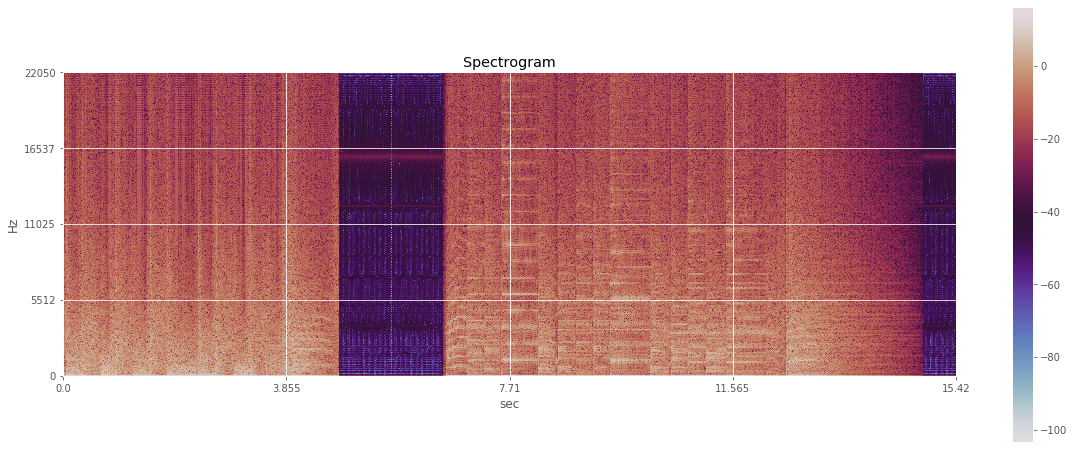

In [15]:
spect_noise_filter, wind_l = Sp.make_spectrogram(x_noise_filter,wind_n)
Sp.plot_spectrogramm (spect_noise_filter.T, sr, wind_l, len(x), wind_n)

# Задачи 7. Выделение гармоник.

In [21]:
#wind_n = 1000
#spect, wind_l = Sp.make_spectrogram(x,wind_n)

**Главной гармоникой** будем называть частоту, обладающую максимальной амплитудой (после Фурье преобразования). Аналогично можно попытаться выделить второе и третье максимальное значение. Посмотрим на зависимость гармоник от времени. Как и при построении спектрограммы рассмотрим окна. Для каждого окна найдем частоту, на которой достигается максимум амплитуд и построим график зависимости таких частот от номера окна (это то же самое, что и от времени).

Проблема выделения пика амплитуды связана с зашумленностью файла. Для приблеженного поиска положения максимума предлагается использовать некоторые методы сглаживания функции (результат их действия показан ниже на примере распределения амплитуд для некоторого окна):
+ boxed mean - оконное среднее, выбирается окошко заданной длины, которое "едет" по элементам массива, заменяя их на среднее в этом окне
+ boxed weights mean - оконное среднее с весом, выбирается окошко заданной длины, которое "едет" по элементам массива, заменяя их на взвешенное среднее в этом окне (т.е. все элементы при подсчете суммы берутся с некоторым весом - чем ближе слагаемое к элементу, тем больше его вес)
+ gaussian filtr - фильтр гаусса, библиотечная функция `scipy.ndimage.gaussian_filter1d`

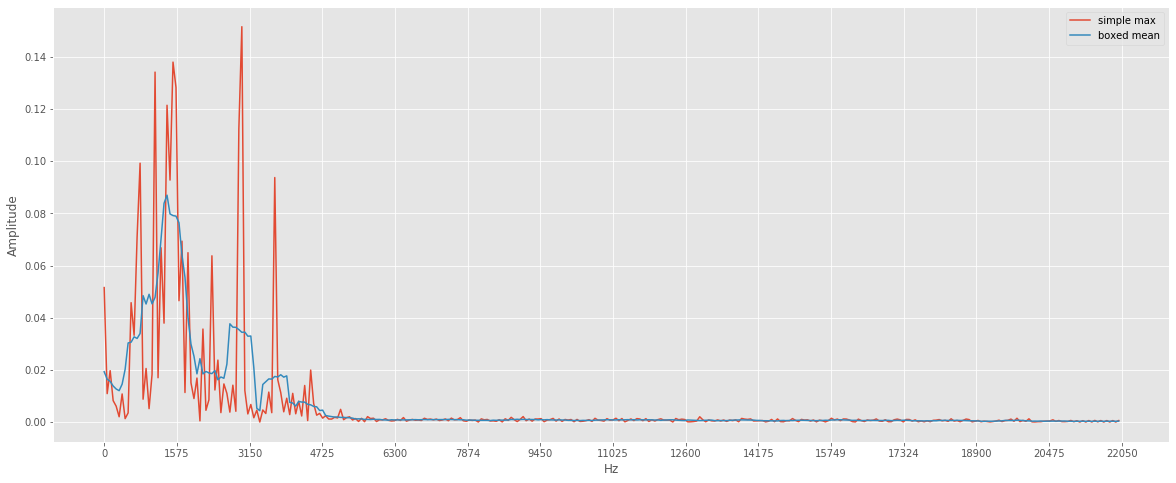

In [38]:
plot_amplitude(spect,-66, sr, simple = True, mean = True, mean_w = False, gauss = False)

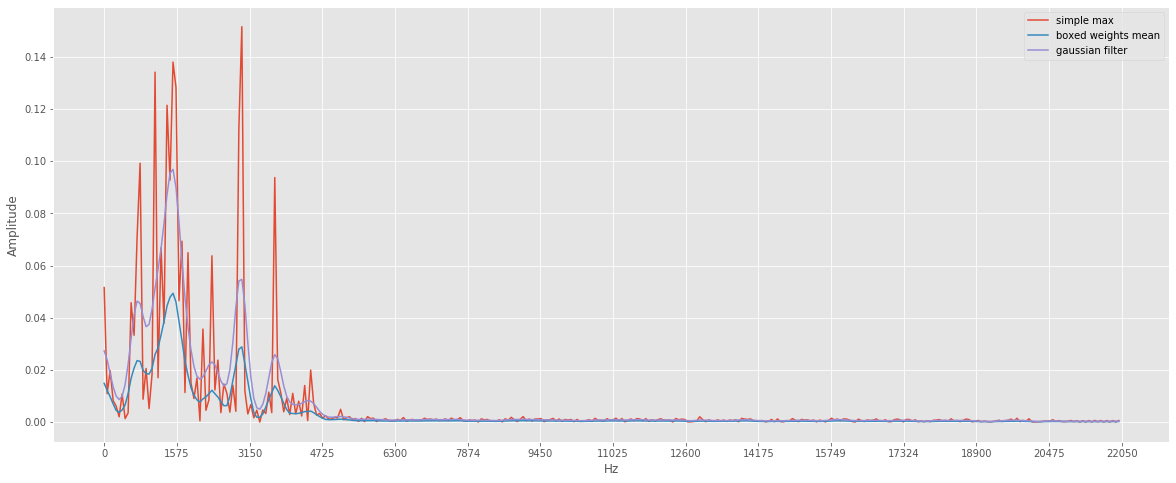

In [40]:
plot_amplitude(spect,-66, sr, simple = True, mean = False, mean_w = True, gauss = True)

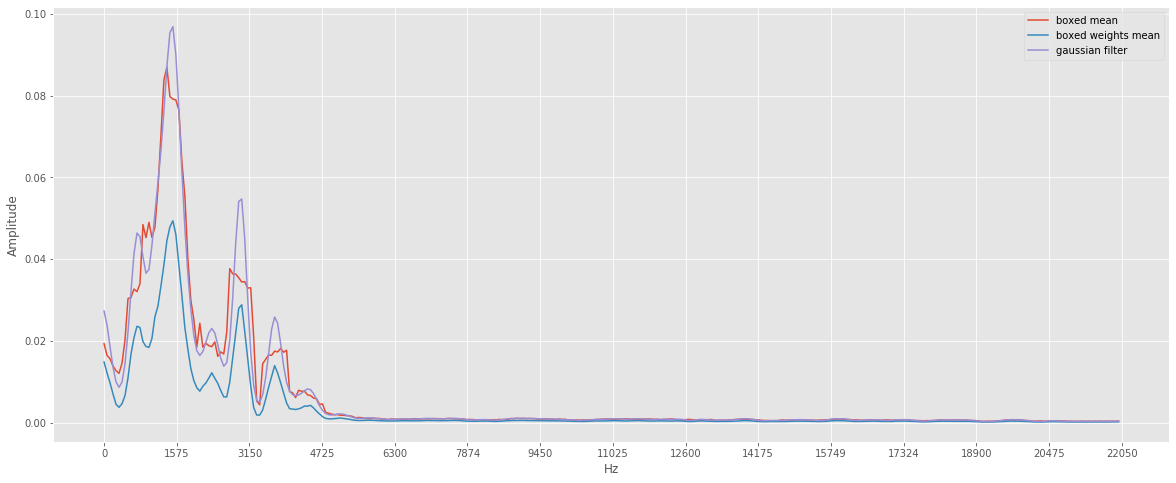

In [41]:
plot_amplitude(spect,-66, sr, simple = False, mean = True, mean_w = True, gauss = True)

Ниже на примере разпределений амплитуд для некоторого окна показано, какие значения выбираются в качестве первых трех гармоник (для сглаживания выбран метод взвешенного оконного среднего). 

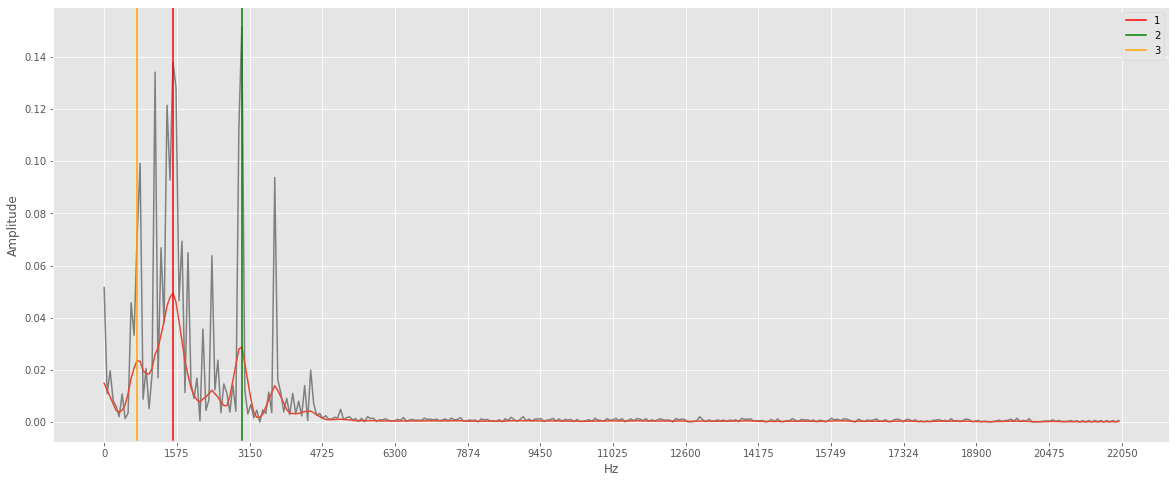

In [44]:
show_3_max(spect, -66, sr, smooth_function = H.smoothing_mean_w)

# Задача 8. Гармоники. График

Ниже представлены грыфики зависимости гармоник от времени. Если не сглаживать амплитуды (первый блок картинок), первая гармоника в конце (примерно 13s - 15s) сильно зашумлена. На самом деле, моей основной задачей было его убрать. При проведении тестов лучшим образом показали склаживание путем оконного взвешенного среднего и фильтр гаусса. Поэтому продемонстрируем результаты для них, минуя сглаживание путем оконного среднего (без веса).

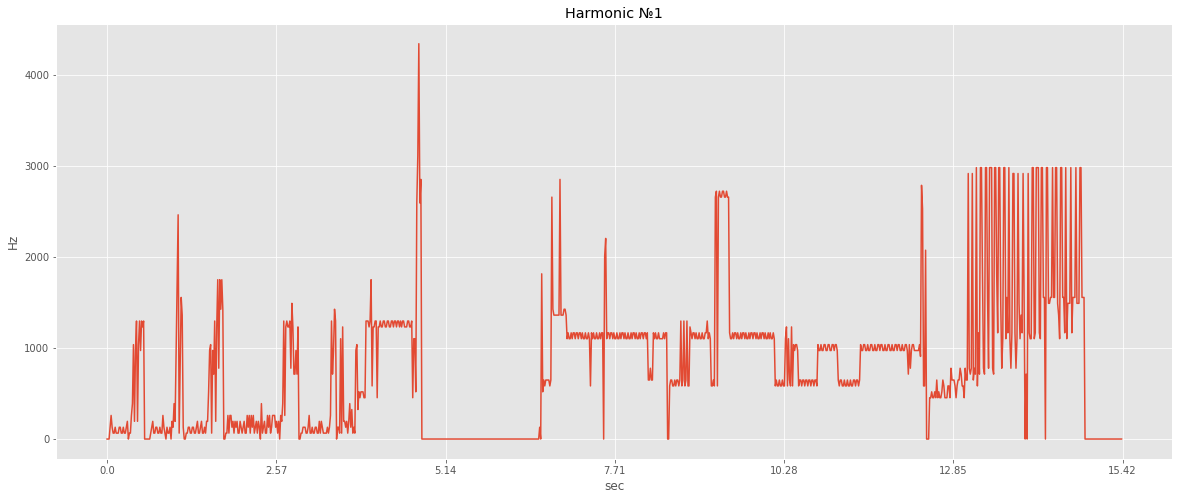

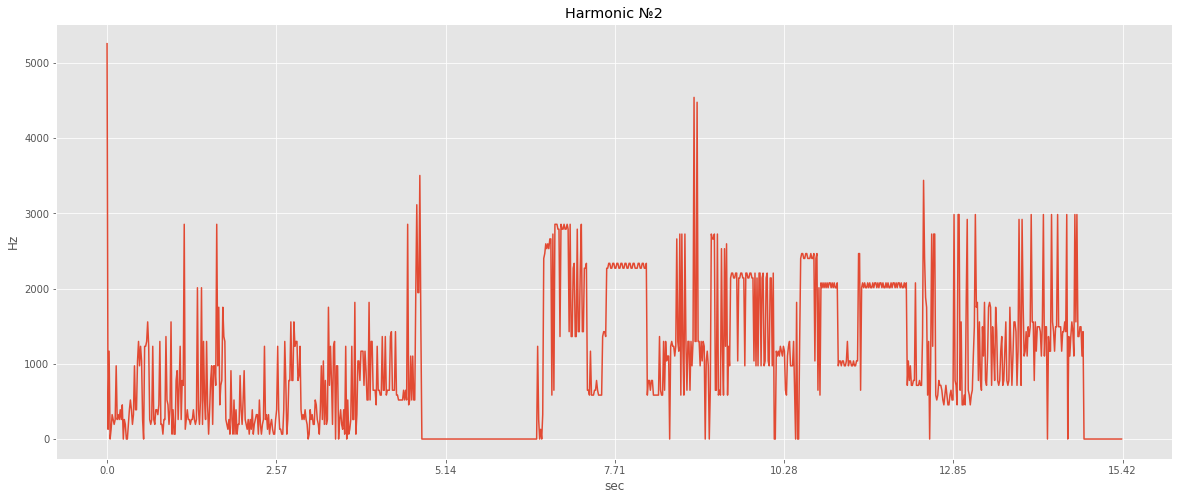

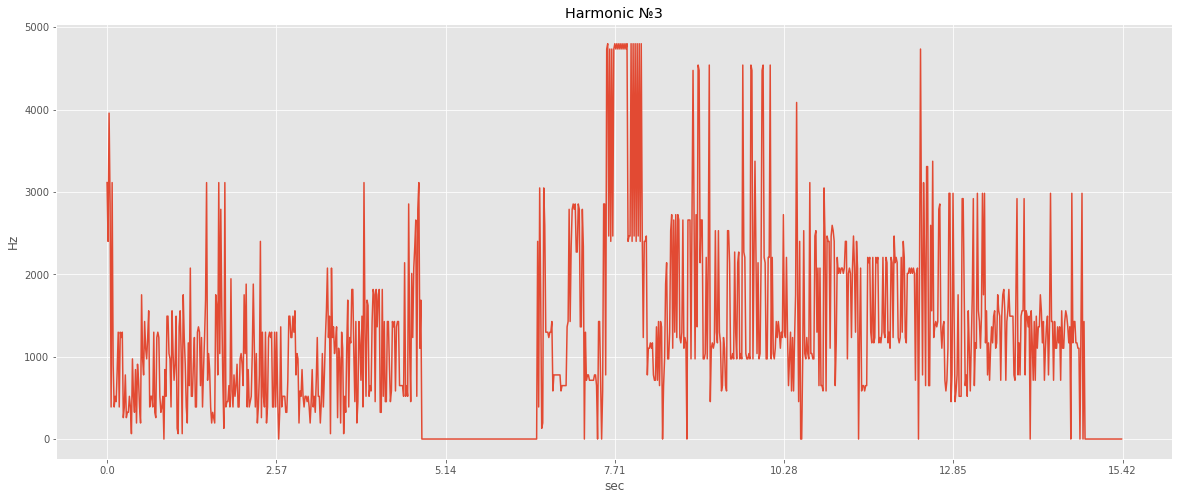

In [14]:
harmonics_simple = H.find_harmonics(sr, spect, smoothing_function = H.without_smothing)
for i in range(3):
    H.plot_harmonic(harmonics_simple[i],i,x.shape[0],sr,wind_l,wind_n)

Сглаживание путем взвешенного среднего.

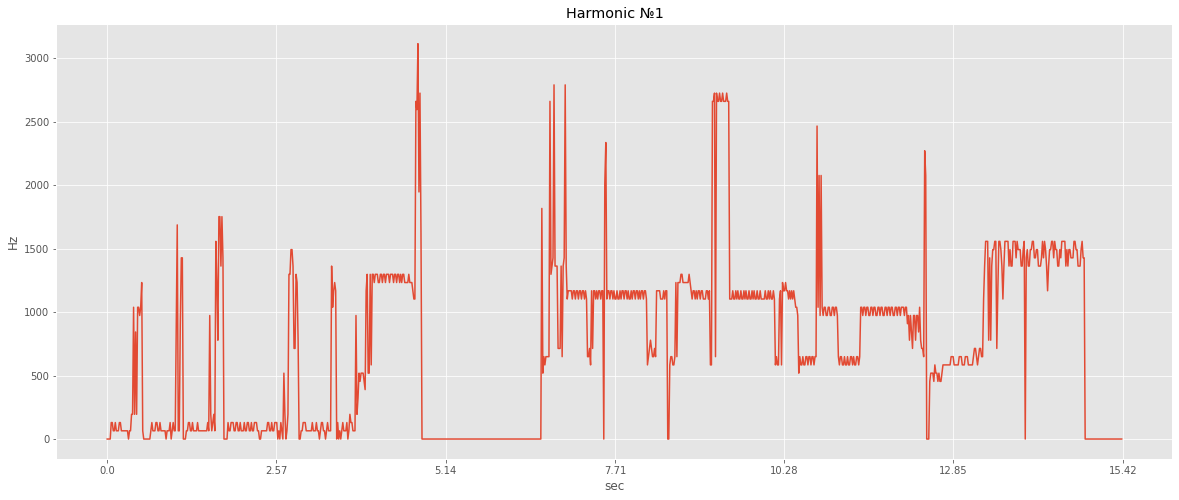

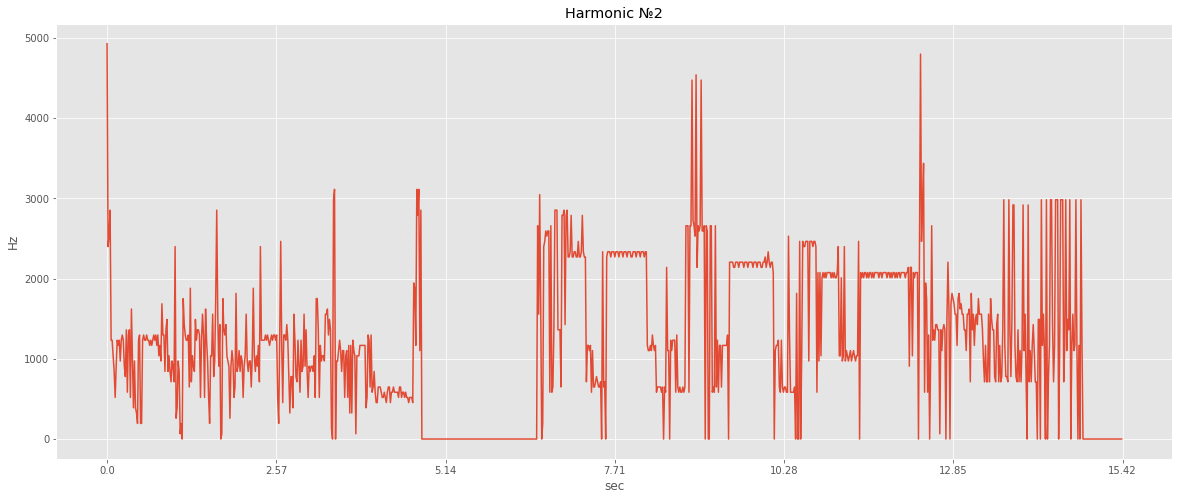

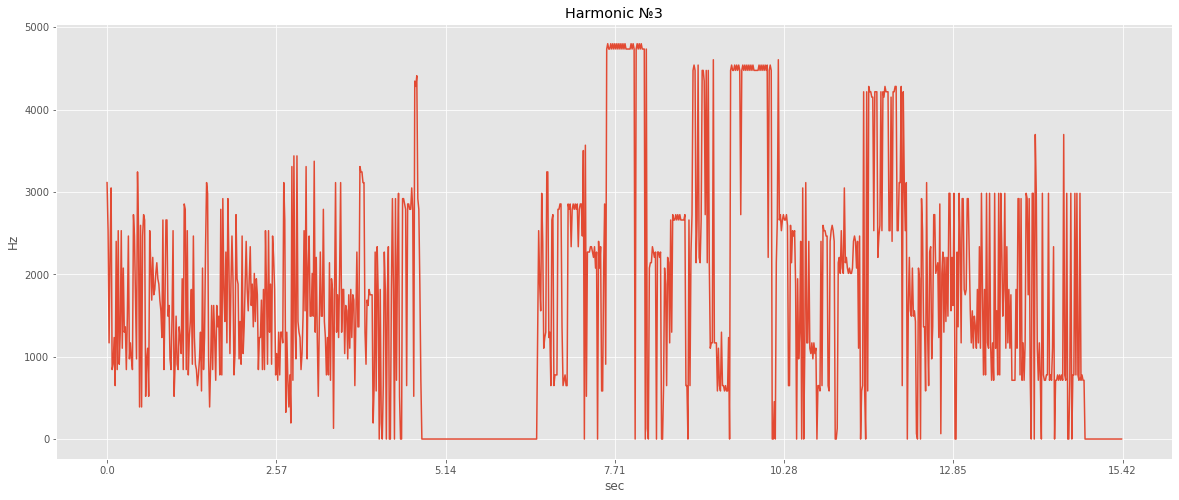

In [11]:
harmonics_mw = H.find_harmonics(sr, spect, smoothing_function = H.smoothing_mean_w)
for i in range(3):
    H.plot_harmonic(harmonics_mw[i],i,x.shape[0],sr,wind_l,wind_n)

Фильтр Гаусса дает очень похожий результат.

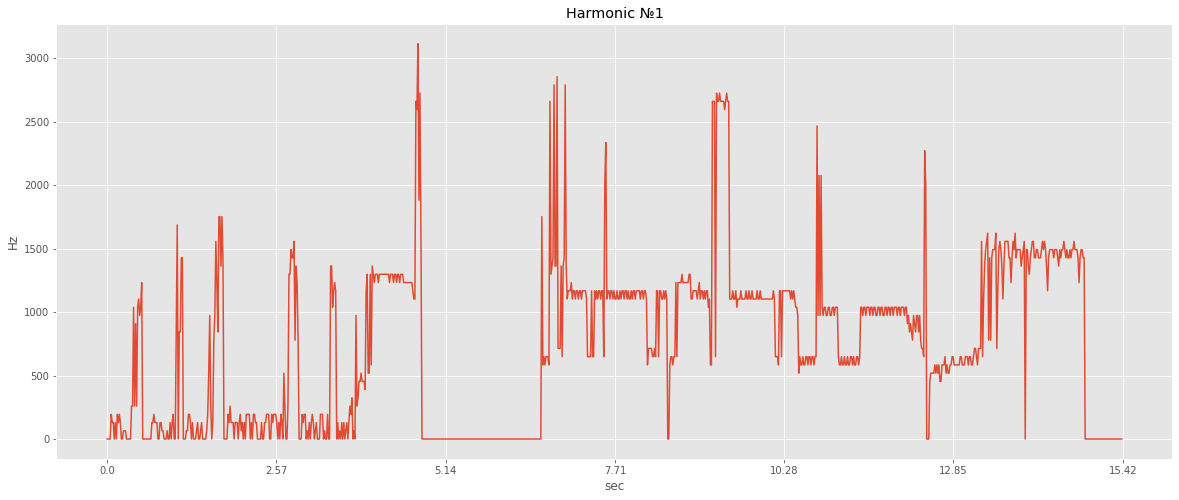

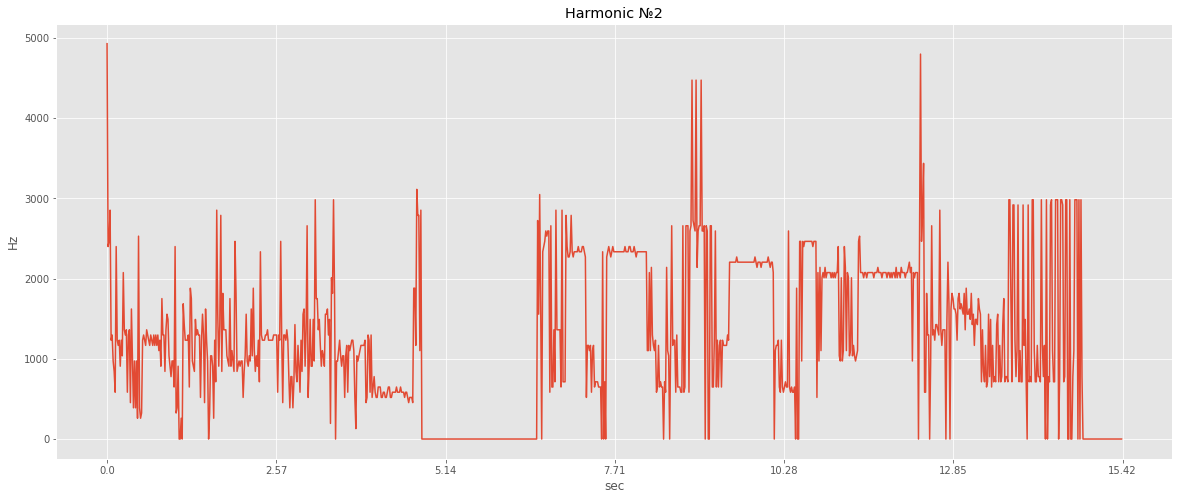

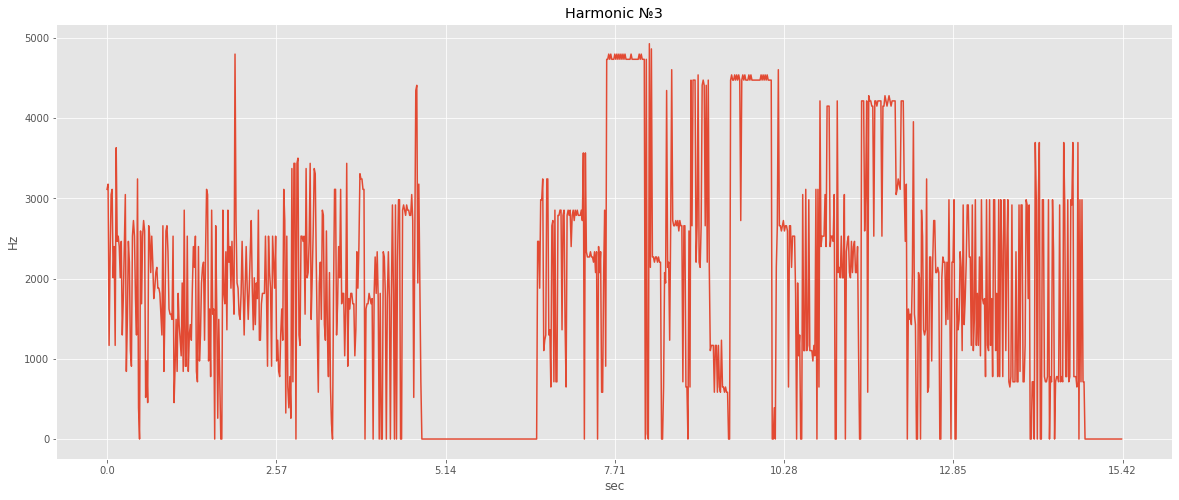

In [16]:
harmonics_mw = H.find_harmonics(sr, spect, smoothing_function = H.gaussian_filter)
for i in range(3):
    H.plot_harmonic(harmonics_mw[i],i,x.shape[0],sr,wind_l,wind_n)